In [385]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt 

In [386]:
sns.set(rc={'figure.figsize': (12,8)})

In [387]:
assessments = pd.read_csv('/mnt/HC_Volume_18315164/home-jupyter/jupyter-s-cherepanov-22/Проект e-learning/assessments.csv')

In [388]:
courses = pd.read_csv('/mnt/HC_Volume_18315164/home-jupyter/jupyter-s-cherepanov-22/Проект e-learning/courses.csv')

In [389]:
studentAssessment = pd.read_csv('/mnt/HC_Volume_18315164/home-jupyter/jupyter-s-cherepanov-22/Проект e-learning/studentAssessment.csv')

In [390]:
studentRegistration = pd.read_csv('/mnt/HC_Volume_18315164/home-jupyter/jupyter-s-cherepanov-22/Проект e-learning/studentRegistration.csv')

In [391]:
assessments.head()

,code_module,code_presentation,id_assessment,assessment_type,date,weight
0,AAA,2013J,1752,TMA,19.0,10.0
1,AAA,2013J,1753,TMA,54.0,20.0
2,AAA,2013J,1754,TMA,117.0,20.0
3,AAA,2013J,1755,TMA,166.0,20.0
4,AAA,2013J,1756,TMA,215.0,30.0


In [392]:
studentRegistration.head()

,code_module,code_presentation,id_student,date_registration,date_unregistration
0,AAA,2013J,11391,-159.0,NaN
1,AAA,2013J,28400,-53.0,NaN
2,AAA,2013J,30268,-92.0,12.0
3,AAA,2013J,31604,-52.0,NaN
4,AAA,2013J,32885,-176.0,NaN


In [393]:
courses.head()

,code_module,code_presentation,module_presentation_length
0,AAA,2013J,268
1,AAA,2014J,269
2,BBB,2013J,268
3,BBB,2014J,262
4,BBB,2013B,240


In [394]:
studentAssessment.head()

,id_assessment,id_student,date_submitted,is_banked,score
0,1752,11391,18,0,78.0
1,1752,28400,22,0,70.0
2,1752,31604,17,0,72.0
3,1752,32885,26,0,69.0
4,1752,38053,19,0,79.0


### 1. Сколько студентов успешно сдали только один курс? (Успешная сдача — это зачёт по курсу на экзамене)

In [395]:
full_assessment = studentAssessment.merge(assessments,on='id_assessment') #'Склеиваем' два датафрейма по id_assessment,
                                                                          #чтобы получить в новом дф тип экзамена

## Сортируем получившийся датафрейм, оставляя в нём только положительно сданные экзамены.
### Оставляем студентов, сдавших только один экзамен, выводим количество строк датафрейма

In [396]:
full_assessment.query('score >= 40 and assessment_type == "Exam" and is_banked == 0')\
                 .groupby('id_student',as_index=False)\
                 .agg({'id_assessment':'count'})\
                 .query('id_assessment == 1 ')\
                 .shape[0]

3802

# Итого:
## 3802 студента сдали только один экзамен

### 2. Выяви самый сложный и самый простой экзамен: найди курсы и экзамены в рамках курса,  которые обладают самой низкой и самой высокой завершаемостью*.

In [397]:
full_assessment_Exams = full_assessment.query('assessment_type == "Exam" and is_banked == 0') #Оставляем только экзамены

In [398]:
def is_passed(score): #Функция , которая возвращает 1 если экзамен сдан и 0 если не сдан
    if score >= 40:
        return 1
    else:
        return 0

In [399]:
full_assessment_Exams['is_passed'] = full_assessment_Exams.score.apply(is_passed) #Применяем функцию , создавая новый столбец

/opt/tljh/user/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


### Группируем два разных датафрейма по ID экзамена и склеиваем их. В одном случае считаем количество строчек (количество попыток сдать), а в другом сумму(успешные попытки)

In [400]:
Difficulty_of_exams = full_assessment_Exams.groupby('id_assessment',as_index = False)\
                                         .agg({'is_passed':'count'})\
                                         .rename(columns={'is_passed':'attempts'})\
                                         .merge(full_assessment_Exams.groupby('id_assessment',as_index = False)\
                                         .agg({'is_passed':'sum'}),on='id_assessment')

In [401]:
Difficulty_of_exams['completion ,%'] = (Difficulty_of_exams.is_passed / Difficulty_of_exams.attempts) * 100

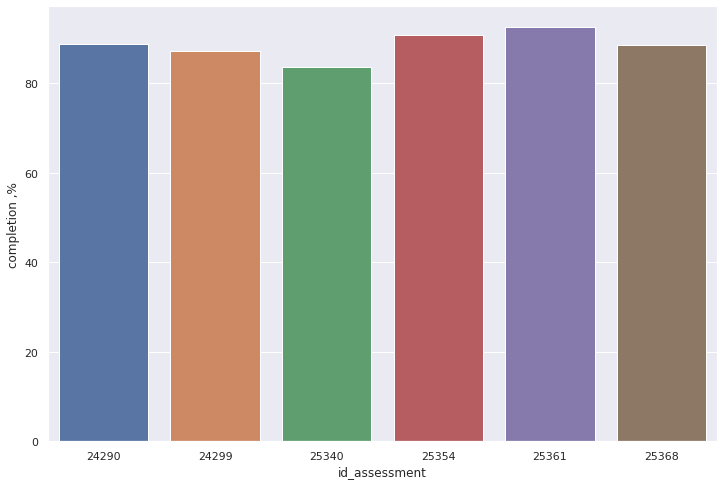

In [402]:
sns.barplot(x=Difficulty_of_exams.id_assessment,y=Difficulty_of_exams['completion ,%'])

### Расчитаем самый сложный и простой курс(предмет) в общем случае(не только экзамены), используя те же самые функции.

In [403]:
full_assessment['is_passed'] = full_assessment.score.apply(is_passed)

In [404]:
Difficulty_of_courses = full_assessment.groupby('code_module',as_index = False)\
                                         .agg({'is_passed':'count'})\
                                         .rename(columns={'is_passed':'attempts'})\
                                         .merge(full_assessment.groupby('code_module',as_index = False)\
                                         .agg({'is_passed':'sum'}),on='code_module')

In [405]:
Difficulty_of_courses['completion ,%'] = (Difficulty_of_courses.is_passed / Difficulty_of_courses.attempts) * 100

In [406]:
Difficulty_of_courses = Difficulty_of_courses.sort_values(by='completion ,%',ascending=False)

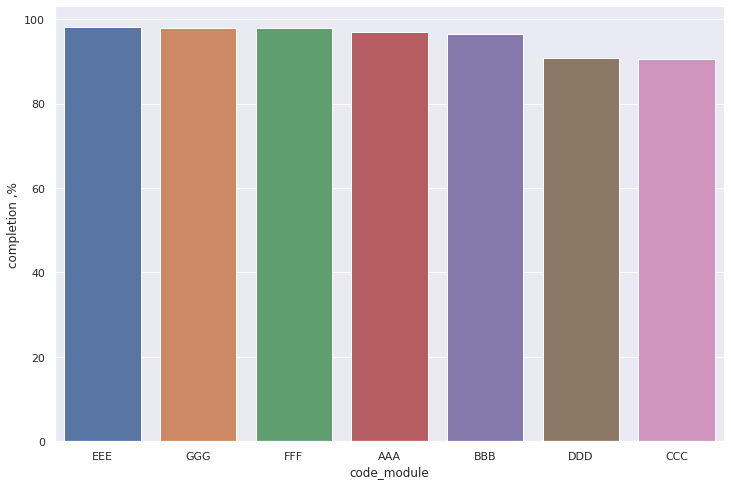

In [407]:
sns.barplot(x=Difficulty_of_courses.code_module,y=Difficulty_of_courses['completion ,%'])

# Итого:
## Что касается экзаменов:
### id_assessment = 25361 - самый простой экзамен в рамках курса
### id_assessment = 25340 - самый сложный экзамен в рамках курса
## Что касается предметов, по завершаемости:
### code_module = CCC - самый "сложный" предмет с низкой завершаемостью
### code_module = EEE - предмет с самой высокой завершаемостью

### 3. По каждому предмету определи средний срок сдачи экзаменов (под сдачей понимаем последнее успешное прохождение экзамена студентом).  Будем считать сроком сдачи экзамена - разницу между сроком последней успешной сдачи экзамена и началом семестра, в котором этот предмет изучается

### Связываем между собой названия предметов и id экзаменово по ним

In [408]:
courses_and_assessments = courses.merge(assessments,on='code_module').query('assessment_type == "Exam"')[['id_assessment','code_module']]

### Список всех id экзаменов

In [409]:
assessments_list = list(courses_and_assessments.id_assessment)

### Считаем средний срок сдачи определенного экзамена студентами

In [410]:
mean_assessment = studentAssessment.query('id_assessment in @assessments_list and is_banked == 0')\
                  .query('score >=40')\
                  .groupby(['id_assessment'],as_index=False)\
                  .agg({'date_submitted':'mean'})

### Склеиваем результаты с первоначальной таблицей и считаем среднее уже по предметам

In [411]:
mean_assessment.merge(courses_and_assessments,on='id_assessment')\
               .groupby('code_module',as_index=False)\
               .agg({'date_submitted':'mean'})

,code_module,date_submitted
0,CCC,237.992822
1,DDD,236.853479


# Выяви самые популярные курсы (ТОП-3) по количеству регистраций на них. А также курсы с самым большим оттоком (ТОП-3). (8 баллов)

### Если студент без даты регистрации , считаем , что это либо ошибка в данных, либо регистрация была в другом семестре .Оба случая нам не подходят

In [412]:
studentRegistration_without_nan = studentRegistration.dropna(axis='index', how='any', subset=['date_registration'])

### Считаем самые популярные курсы, сортируем по убыванию

In [413]:
MostPopularCourses = studentRegistration_without_nan.groupby('code_module',as_index=False)\
                   .agg({'date_registration':'count'})\
                   .sort_values(by='date_registration',ascending=False)\
                   .rename(columns={'date_registration':'count_of_registations'})
                    
                

In [414]:
MostPopularCourses

,code_module,count_of_registations
1,BBB,7900
5,FFF,7751
3,DDD,6257
2,CCC,4426
4,EEE,2932
6,GGG,2534
0,AAA,748


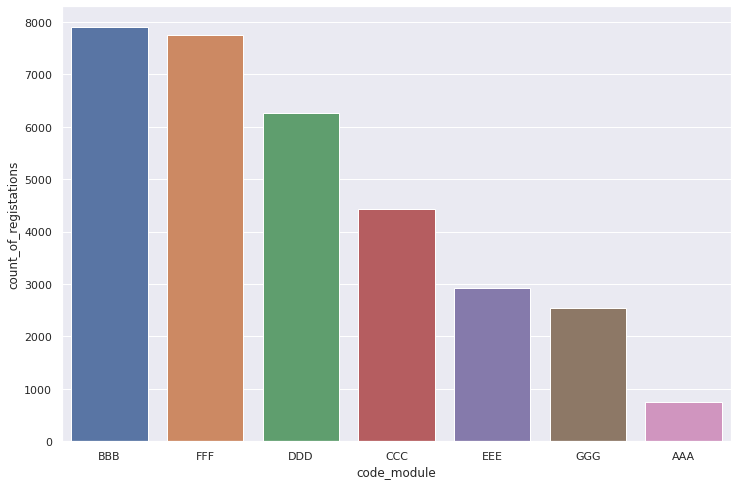

In [415]:
sns.barplot(x='code_module',y='count_of_registations',data = MostPopularCourses);

### Для подсчёта количества оттока, сначала посчитаем общее количество строчек, с date_unregistation.

In [416]:
full_unreg = studentRegistration.groupby('code_module',as_index=False)\
                    .agg({'date_unregistration':'count'})\
                    .rename(columns={'date_unregistration':'full_unreg'})\
                    .sort_values('full_unreg',ascending=False)

In [417]:
full_unreg

,code_module,full_unreg
5,FFF,2380
1,BBB,2377
3,DDD,2235
2,CCC,1947
4,EEE,718
6,GGG,289
0,AAA,126


### Затем посчитаем количество реально отписавшихся людей, и смерджим два датафрейма

In [418]:
real_unreg = studentRegistration.dropna(axis='index', how='any', subset=['date_registration','date_unregistration'])

In [419]:
real_unreg = real_unreg.groupby('code_module',as_index=False)\
                    .agg({'date_unregistration':'count'})\
                    .rename(columns={'date_unregistration':'real_unreg'})\
                    .sort_values('real_unreg',ascending=False)

In [420]:
worst_courses = real_unreg.merge(full_unreg,on='code_module')

### Посчитаем количество отписавшихся в процентах, и построим барплот

In [421]:
worst_courses['amount_of_unsubscribers , %'] = (1 - worst_courses.real_unreg/worst_courses.full_unreg)*100

In [422]:
worst_courses = worst_courses.sort_values(by='amount_of_unsubscribers , %',ascending=False)

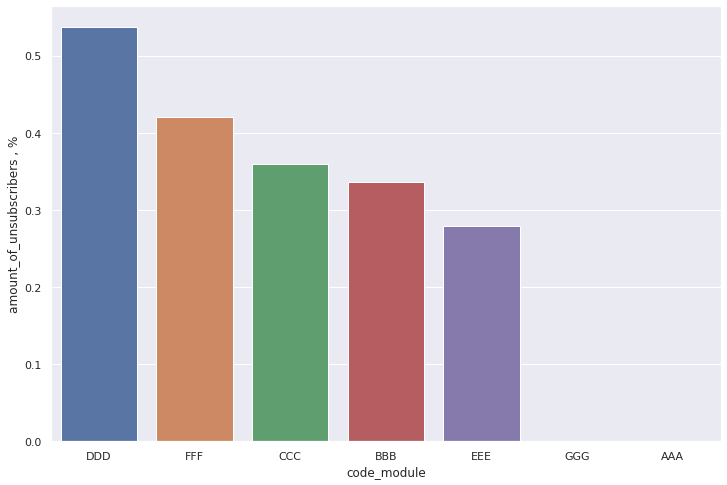

In [423]:
sns.barplot(y='amount_of_unsubscribers , %',x='code_module',data = worst_courses);

# Итого
## ТОП-3 курса с наибольшим количеством регистраций:
### BBB
### FFF
### DDD
## ТОП-3 курса с наибольшим оттоком:
### DDD
### FFF
### CCC

# 5. Напиши функцию на python, позволяющую строить когортный (семестровый) анализ. В период с начала 2013 по конец 2014 выяви семестр с самой низкой завершаемостью курсов и самыми долгими средними сроками сдачи курсов. 

### Сначала посчитаем средний срок сдачи курсов по семестрам:

### Формируем датафрейм для когортного анализа, убираем из него пустые значения и значения студентов с неудами или фактами перезачёта(считать их в статистике не имеет смысла, т.к время перезачёта во всех этих ячейках -1 ,т.е до начала семестра)

In [424]:
df_for_cohort = assessments.merge(studentAssessment,on='id_assessment').drop(columns=['weight','date']).dropna().query('is_banked == 0 and score>=40')

In [425]:
df_for_cohort = df_for_cohort.groupby(['code_presentation','code_module'],as_index=False)\
                              .agg({'date_submitted':'mean'})\
                             .rename(columns={'date_submitted':'mean_date_submitted'})

### Формируем сводную таблицу

In [426]:
cohort_pivot = df_for_cohort.pivot_table(index='code_module',columns='code_presentation',values='mean_date_submitted').round(2)

### Строим sns.heatmap .Точные выводы по нему сделать проблематично, хотя видно некоторые тенденции(самая долгая средняя сдача в 2013J и 2014J)

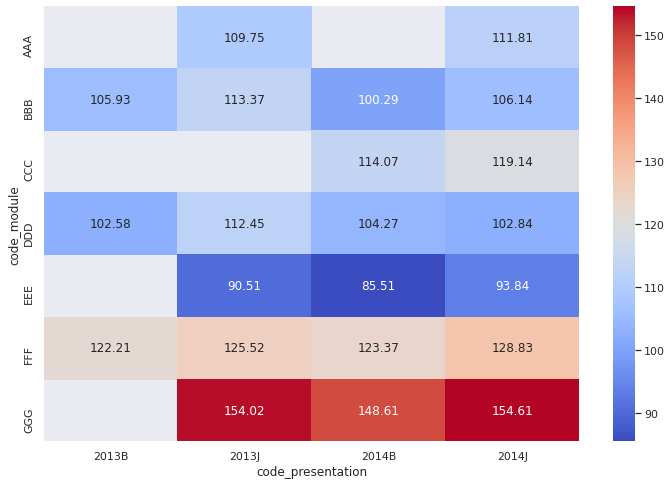

In [427]:
sns.heatmap(cohort_pivot,cmap='coolwarm',annot=True, fmt=".2f")

### С помощью функции describe убеждаемся, что 2013J - семестр с самой долгой средней сдачей курсов

In [428]:
cohort_pivot.describe()

code_presentation,2013B,2013J,2014B,2014J
count,3.000000,6.000000,6.000000,7.000000
mean,110.240000,117.603333,112.686667,116.744286
std,10.500776,21.114207,21.769804,20.167423
min,102.580000,90.510000,85.510000,93.840000
25%,104.255000,110.425000,101.285000,104.490000
50%,105.930000,112.910000,109.170000,111.810000
75%,114.070000,122.482500,121.045000,123.985000
max,122.210000,154.020000,148.610000,154.610000


### Чтобы сделать когортный анализ семестров по завершаемости, применим функцию is_passed , сформиров новый столбец.

In [429]:
df_for_cohort2 = assessments.merge(studentAssessment,on='id_assessment').drop(columns=['weight','date']).dropna().query('is_banked == 0')

In [89]:
df_for_cohort2['is_passed'] = df_for_cohort2.score.apply(is_passed)

### Сначала посчитаем общее количество сданных экзаменов, затем просто общее число экзаменов, смерджим датафреймы и посчитаем процент завершаемости

In [90]:
df_for_cohort2 = df_for_cohort2.groupby(['code_presentation','code_module'],as_index=False)\
              .agg({'is_passed':'sum'})\
              .rename(columns={'is_passed':'count_of_passed_exams'})\
              .merge(df_for_cohort2.groupby(['code_presentation','code_module'],as_index=False)\
              .agg({'is_passed':'count'})\
              .rename(columns={'is_passed':'max_of_passed_exams'}),on=['code_presentation','code_module'])

In [91]:
df_for_cohort2['completion,%'] = (df_for_cohort2.count_of_passed_exams / df_for_cohort2.max_of_passed_exams) * 100

In [92]:
df_for_cohort2 = df_for_cohort2.drop(columns=['count_of_passed_exams','max_of_passed_exams'])

### Строим сводную таблицу и по ней heatmap , а также применяем функцию describe()

In [93]:
df_for_cohort2_pivot = df_for_cohort2.pivot(index='code_module',columns='code_presentation',values='completion,%')

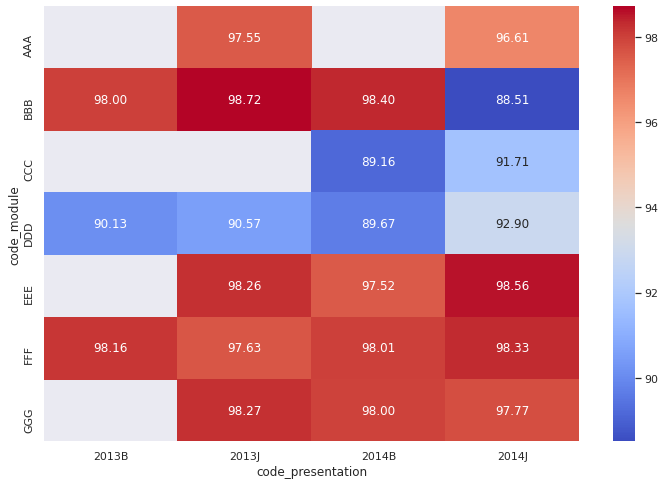

In [278]:
sns.heatmap(df_for_cohort2_pivot,cmap='coolwarm',annot=True, fmt='.2f');

In [95]:
df_for_cohort2_pivot.describe()

code_presentation,2013B,2013J,2014B,2014J
count,3.000000,6.000000,6.000000,7.000000
mean,95.428830,96.832429,95.126055,94.913095
std,4.593720,3.100529,4.434562,3.899686
min,90.125255,90.567010,89.163549,88.510408
25%,94.063163,97.568294,91.632212,92.309071
50%,98.001071,97.947559,97.760937,96.605567
75%,98.080618,98.267585,98.003827,98.050228
max,98.160164,98.716312,98.396814,98.557089


# 2014J - семестр с наименьшим процентом завершаемости курсов

## 6. Часто для качественного анализа аудитории использую подходы, основанные на сегментации. Используя python, построй    адаптированные RFM-кластеры студентов, чтобы качественно оценить свою аудиторию. В адаптированной кластеризации можешь выбрать следующие метрики: R - среднее время сдачи одного экзамена, F - завершаемость курсов, M - среднее количество баллов, получаемое за экзамен.

## Для начала построим RFM кластеры для студентов, учитывая и экзамены, и обычные тесты(почему так, будет объяснено чуть позже)

In [350]:
data_for_RFM = studentAssessment.merge(studentRegistration,on='id_student')

### Студентов без даты регистрации на курс и количества баллов за экзамен отбросим( их около 300 человек, считаем это багом системы) . В анализе они в любом случае не сыграют роли

In [351]:
data_for_RFM = data_for_RFM.dropna(subset=['date_registration','score'])

### Для каждого теста/экзамена определяем сдан он или нет с помощью функции , определенной выше

In [352]:
data_for_RFM['is_passed'] = data_for_RFM.score.apply(is_passed)

### Выделим отдельно студентов, у которых есть перезачёты, т.к использовать их для подсчёта средней сдачи экзамена особо не имеет смысла(у них в графе da_submitted значение -1)

In [353]:
guys_with_recalculations = data_for_RFM.query('is_banked == 1').groupby(['id_student'],as_index=False).agg({'date_submitted':'count'})\
                                    .rename(columns={'date_submitted':'amount_of_recalculations'})

### Считаем среднее время сдачи экзаменов/тестов и среднее количество баллов, мерджим датафреймы

In [354]:
data_dates = data_for_RFM.query('is_banked == 0').groupby(['id_student'],as_index=False).agg({'date_submitted':'mean'}).merge(guys_with_recalculations,how='outer')

In [355]:
data_score = data_for_RFM.groupby('id_student',as_index=False)\
            .agg({'score':'mean'})

In [356]:
data_for_RFM = data_for_RFM.groupby(['id_student'],as_index=False)\
            .agg({'is_passed':'mean'})\
            .merge(data_dates,on='id_student')\
            .merge(data_score,on='id_student')

# Формируем кластеры:
## Кластер F:
### Значения меньше 0.4 - самые слабые ученики с бОльшим количеством несдач экзаменов/тестов

### Значения от 0.4 до 1 - 'среднячки', у которых бывали незачёты, но в большинстве своём они сдавали экзамены/тесты с первого раза на уд. и выше

### Значение 1 - студенты, которые ни разу не провалили ни одного теста

## Кластер M:
### Значения меньше перцентиля баллов 25 - самые слабые ученики с плохим средним баллом

### Значения от перцентиля 25 до 75 - среднячки

### Значение перцентиля 75+ - "отличники"

## Кластер R:
### Значения больше перцентиля средней сдачи экзамена 60 - самые долгие студенты
### Значения от перцентиля средней сдачи экзамена от 40 до 60 - студенты со средней длительностью сдачи экзаменов
### Значение перцентиля средней сдачи экзамена меньше 40 - самые быстрые студенты
### В отдельную группу(4) я вынес студентов, которые, имеют перезачёты(считать их используя функцию неправильно)

In [357]:
def F(x):
    if x < 0.4:
        return '1'
    elif x>=0.4 and x<1:
        return '2'
    elif x == 1:
        return '3'

In [358]:
def M(x,quantile_score_25 , quantile_score_75):
    if x < quantile_score_25:
        return '1'
    elif x >= quantile_score_25 and x <= quantile_score_75:
        return '2'
    elif x > quantile_score_75:
        return '3'

In [359]:
def R(x , quantile_date_60,quantile_date_40):
    if x > quantile_date_60:
        return '1'
    elif x>=quantile_date_40 and x <= quantile_date_60:
        return '2'
    elif x < quantile_date_40:
        return '3'

In [360]:
quantile_score_25 = data_for_RFM.score.quantile(0.25)
quantile_score_75 = data_for_RFM.score.quantile(0.75)
quantile_date_60 = data_for_RFM.date_submitted.quantile(0.6)
quantile_date_40 = data_for_RFM.date_submitted.quantile(0.4)

In [361]:
data_for_RFM['F'] = data_for_RFM.is_passed.apply(F)

In [362]:
data_for_RFM['M'] = data_for_RFM.score.apply(M,args=(quantile_score_25 , quantile_score_75))

### Студентам с перезачётами я присваиваю значение R=4

In [363]:
null_data = data_for_RFM[data_for_RFM.isnull().any(axis=1)==False]

In [364]:
null_data['R'] = '4'

/opt/tljh/user/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


### Отдельно считаю R для студентов с перезачётами и без. Потом соединяю два дф

In [365]:
data_for_RFM = data_for_RFM[data_for_RFM.isnull().any(axis=1)]

In [366]:
data_for_RFM['R'] = data_for_RFM.date_submitted.apply(R, args=(quantile_date_60,quantile_date_40))

In [367]:
data_for_RFM = pd.concat([data_for_RFM,null_data],axis=0)

### Последнее действие - формирую RFM и оставляю в итоговом DF только данные об ID студента и категории , к которой он относится

In [368]:
data_for_RFM['RFM'] = data_for_RFM.R + data_for_RFM.F + data_for_RFM.M

In [369]:
data_for_RFM = data_for_RFM[['id_student','RFM']]

In [370]:
data_for_RFM

,id_student,RFM
0,6516,231
2,11391,232
3,23629,332
4,23698,132
5,23798,133
...,...,...
23140,2646737,421
23210,2667478,433
23254,2681198,421
23268,2683857,432


### Строим барплоты с распределением количества студентов по группам

In [371]:
for_graph = data_for_RFM.groupby('RFM',as_index=False)\
            .agg({'id_student':'count'})\
            .rename(columns={'id_student':'amount_of_students'})

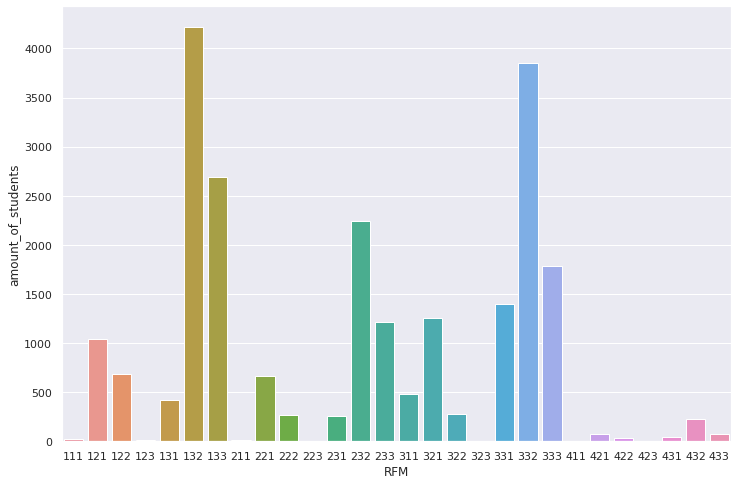

In [372]:
sns.barplot(x=for_graph.RFM,y=for_graph.amount_of_students)

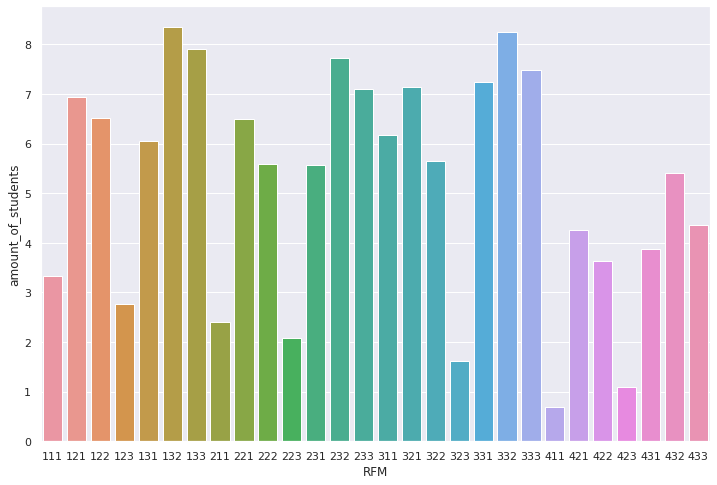

In [373]:
sns.barplot(x=for_graph.RFM,y=np.log(for_graph.amount_of_students))

# Выполним те же действия, анализируя только экзамены

### Оказывается, фактов перезачёта экзаменов нет (очень странно) , поэтому дополнительный ячейка кластера нам не понадобится.
### Кроме того , после того , оказалось, что экзаменов сдавало намного меньше студентов(именно поэтому я разбил задание на 2 части)

In [374]:
exams = list(assessments.query("assessment_type == 'Exam'").id_assessment)

In [375]:
studentAssessment.merge(studentRegistration,on='id_student').query('id_assessment in @exams and is_banked == 1')

,id_assessment,id_student,date_submitted,is_banked,score,code_module,code_presentation,date_registration,date_unregistration


In [376]:
data_for_RFM_exams = studentAssessment.merge(studentRegistration,on='id_student').query('id_assessment in @exams')
data_for_RFM_exams = data_for_RFM_exams.dropna(subset=['date_registration','score'])
data_for_RFM_exams['is_passed'] = data_for_RFM_exams.score.apply(is_passed)
data_dates_exams = data_for_RFM_exams.groupby(['id_student'],as_index=False)\
                         .agg({'date_submitted':'mean'})
data_score_exams = data_for_RFM_exams.groupby('id_student',as_index=False)\
            .agg({'score':'mean'})
data_for_RFM_exams = data_for_RFM_exams.groupby(['id_student'],as_index=False)\
            .agg({'is_passed':'mean'})\
            .merge(data_dates_exams,on='id_student')\
            .merge(data_score_exams,on='id_student')

### Проходили экзамены(type_assessment == exam) всего 4633 человека

In [377]:
data_for_RFM_exams

,id_student,is_passed,date_submitted,score
0,23698,1.0,243.0,80.0
1,24213,1.0,236.0,58.0
2,27116,1.0,243.0,96.0
3,28046,1.0,237.0,40.0
4,28787,1.0,243.0,44.0
...,...,...,...,...
4628,2694886,1.0,236.0,69.0
4629,2694933,1.0,230.0,73.0
4630,2695608,1.0,237.0,73.0
4631,2697181,1.0,230.0,80.0


In [378]:
quantile_score_25 = data_for_RFM_exams.score.quantile(0.25)
quantile_score_75 = data_for_RFM_exams.score.quantile(0.75)
quantile_date_60 = data_for_RFM_exams.date_submitted.quantile(0.6)
quantile_date_40 = data_for_RFM_exams.date_submitted.quantile(0.4)

In [379]:
data_for_RFM_exams['R'] = data_for_RFM_exams.date_submitted.apply(R, args=(quantile_date_60,quantile_date_40))
data_for_RFM_exams['F'] = data_for_RFM_exams.is_passed.apply(F)
data_for_RFM_exams['M'] = data_for_RFM_exams.score.apply(M,args=(quantile_score_25 , quantile_score_75))

In [380]:
data_for_RFM_exams['RFM'] = data_for_RFM_exams.R + data_for_RFM_exams.F + data_for_RFM_exams.M
data_for_RFM_exams = data_for_RFM_exams[['id_student','RFM']]

In [381]:
data_for_RFM_exams

,id_student,RFM
0,23698,132
1,24213,332
2,27116,133
3,28046,231
4,28787,131
...,...,...
4628,2694886,332
4629,2694933,332
4630,2695608,232
4631,2697181,332


In [382]:
for_graph_exams = data_for_RFM_exams.groupby('RFM',as_index=False)\
            .agg({'id_student':'count'})\
            .rename(columns={'id_student':'amount_of_students'})

## Получаем аналогичную сегментацию студентов, которые сдавали экзамены(обычную и логарифмированную версию)

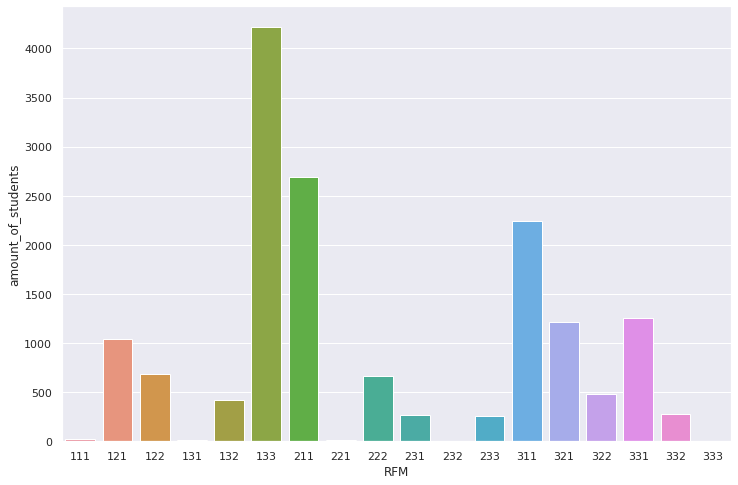

In [383]:
sns.barplot(x=for_graph_exams.RFM,y=for_graph.amount_of_students)

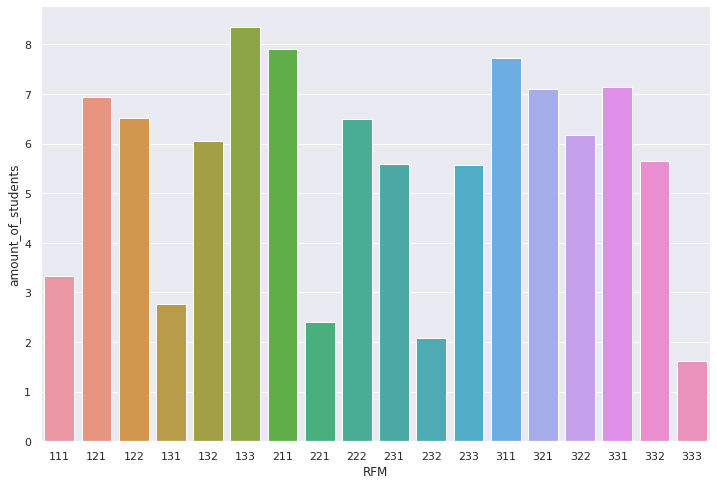

In [384]:
sns.barplot(x=for_graph_exams.RFM,y=np.log(for_graph.amount_of_students))